# XGBoostTreeApproximator Testing
This notebook applies the XGBoostTreeApproximator from Saki & Rokach (2021) to the ELDB Opioid data set.

The tree approximator implementation notebook (FBT.ipynb) should be in the same directory as this notebook.

In [0]:
%run "./FBT"

Writing to /root/.config/pip/pip.conf
Looking in indexes: https://pypi.ccwdata.org/simple
Collecting pyod
 Downloading https://pypi.ccwdata.org/packages/5b/20/b25296da5f26413a44fabc2c72656b01bf4faf2949617dc6840c137736fd/pyod-0.9.9.tar.gz (116 kB)
██▉ | 10 kB 45.3 MB/s eta 0:00:01 |█████▋ | 20 kB 53.2 MB/s eta 0:00:01 |████████▍ | 30 kB 57.6 MB/s eta 0:00:01 |███████████▎ | 40 kB 62.6 MB/s eta 0:00:01 |██████████████ | 51 kB 66.8 MB/s eta 0:00:01 |████████████████▉ | 61 kB 41.9 MB/s eta 0:00:01 |███████████████████▊ | 71 kB 32.8 MB/s eta 0:00:01 |██████████████████████▌ | 81 kB 22.1 MB/s eta 0:00:01 |█████████████████████████▎ | 92 kB 23.8 MB/s eta 0:00:01 |████████████████████████████▏ | 102 kB 25.7 MB/s eta 0:00:01 |███████████████████████████████ | 112 kB 25.7 MB/s eta 0:00:01 |████████████████████████████████| 116 kB 25.7 MB/s 
Requirement already satisfied: joblib in /databricks/python3/lib/python3.8/site-packages (from pyod) (1.0.1)
Requirement already satisfied: matplotlib in /databricks/python3/lib/python3.8/site-packages (from pyod) (3.4.2)
Requirement already satisfied: numpy>=1.13 in /databricks/python3/lib/python3.8/site-packages (from pyod) (1.20.1)
Requirement already satisfied: numba>=0.35 in /databricks/python3/lib/python3.8/site-packages (from pyod) (0.55.1)
Requirement already satisfied: scipy>=1.3.1 in /databricks/python3/lib/python3.8/site-packages (from pyod) (1.6.2)
Requirement already satisfied: scikit_learn>=0.20.0 in /databricks/python3/lib/python3.8/site-packages (from pyod) (0.24.1)
Requirement already satisfied: six in /databricks/python3/lib/python3.8/site-packages (from pyod) (1.15.0)
Requirement already satisfied: statsmodels in /databricks/python3/lib/python3.8/site-packages (from pyod) (0.12.2)
Requirement already satisfied: llvmlite<0.39,>=0.38.0rc1 in /databricks/python3/lib/python3.8/site-packages (from numba>=0.35->pyod) (0.38.0)
Requirement already satisfied: setuptools in /usr/local/lib/python3.8/dist-packages (from numba>=0.35->pyod) (52.0.0)
Requirement already satisfied: threadpoolctl>=2.0.0 in /databricks/python3/lib/python3.8/site-packages (from scikit_learn>=0.20.0->pyod) (2.1.0)
Requirement already satisfied: kiwisolver>=1.0.1 in /databricks/python3/lib/python3.8/site-packages (from matplotlib->pyod) (1.3.1)
Requirement already satisfied: cycler>=0.10 in /databricks/python3/lib/python3.8/site-packages (from matplotlib->pyod) (0.10.0)
Requirement already satisfied: pillow>=6.2.0 in /databricks/python3/lib/python3.8/site-packages (from matplotlib->pyod) (8.2.0)
Requirement already satisfied: pyparsing>=2.2.1 in /databricks/python3/lib/python3.8/site-packages (from matplotlib->pyod) (2.4.7)
Requirement already satisfied: python-dateutil>=2.7 in /databricks/python3/lib/python3.8/site-packages (from matplotlib->pyod) (2.8.1)
Requirement already satisfied: pandas>=0.21 in /databricks/python3/lib/python3.8/site-packages (from statsmodels->pyod) (1.2.4)
Requirement already satisfied: patsy>=0.5 in /databricks/python3/lib/python3.8/site-packages (from statsmodels->pyod) (0.5.1)
Requirement already satisfied: pytz>=2017.3 in /databricks/python3/lib/python3.8/site-packages (from pandas>=0.21->statsmodels->pyod) (2020.5)
Building wheels for collected packages: pyod
 Building wheel for pyod (setup.py) ... - \ | done
 Created wheel for pyod: filename=pyod-0.9.9-py3-none-any.whl size=139312 sha256=239d267e51b3de1ddbb8eaaba8e3826ab5988c5af0c2028d21aa8651610137fc
 Stored in directory: /root/.cache/pip/wheels/43/22/95/8984d995bd70697130d09e144cb6cc398dffecb40335bf7fea
Successfully built pyod
Installing collected packages: pyod
Successfully installed pyod-0.9.9
 WARNING: You are using pip version 21.0.1; however, version 22.1 is available.
You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command.

In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
import xgboost as xgb
import pickle
xgb.__version__

Out[1]: '1.5.2'

## Load datasets
For this evaluation we're only using the (SMOTEENC-encoded) tsfresh dataset. Applying the same methods to other datasets follows the same pattern.

In [0]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

train_split_sql = "MOD(bene_id, 20) < 14"
eval_split_sql = "MOD(bene_id, 20) >= 14 AND MOD(bene_id, 20) < 18"
test_split_sql = "MOD(bene_id, 20) >= 18"

train = spark.table('eldb.opioid_SA_LA_hosp_final_tsfresh_and_demos_train_smoteennc')
eval = spark.table('eldb.opioid_SA_LA_hosp_final_tsfresh_and_demos_ohe').where(eval_split_sql).drop('bene_id')
test = spark.table('eldb.opioid_SA_LA_hosp_final_tsfresh_and_demos_ohe').where(test_split_sql).drop('bene_id')

dtrain = xgb.DMatrix(train.drop('labels').toPandas(), label=train.select('labels').toPandas())
deval = xgb.DMatrix(eval.drop('labels').toPandas(), label=eval.select('labels').toPandas())

In [0]:
print("train: ", train.where('labels > 0').count(),
     "  eval: ", eval.where('labels > 0').count(),
     "  test: ", test.where('labels > 0').count())
print("train: ", train.count(),
     "  eval: ", eval.count(),
     "  test: ", test.count())

train: 439362 eval: 297 test: 145
train: 854635 eval: 130767 test: 65548

## Fit a classifier
The FBT class follows the standard scikit-learn pattern.

For the classifier parameters, we use the `hist` tree method for speed, and include `aucpr` as an eval metric because the class imbalance is high. Note that for this particular experiment we aren't especially concerned with the quality of the XGBoost classifier, but simply comparing it to the performance of the Tree Approximator.

In [0]:
params = {'objective': 'binary:logistic', 
         'eta': 0.1, 
         'max_depth': 8,
         'tree_method': "hist",     
         'subsample': 0.5,
         'nthreads': 2,
         'seed': 42,
         'eval_metric': ['auc', 'aucpr']}
watchlist = [(deval, 'eval'), (dtrain, 'train')]
evals_result = {}
booster = xgb.train(params, dtrain, 2000, watchlist, evals_result=evals_result, early_stopping_rounds=50)


[01:10:13] WARNING: ../src/learner.cc:576: 
Parameters: { "nthreads" } might not be used.

 This could be a false alarm, with some parameters getting used by language bindings but
 then being mistakenly passed down to XGBoost core, or some parameter actually being used
 but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	eval-auc:0.70988	eval-aucpr:0.00999	train-auc:0.98105	train-aucpr:0.98179
[1]	eval-auc:0.72498	eval-aucpr:0.01022	train-auc:0.98333	train-aucpr:0.98389
[2]	eval-auc:0.71937	eval-aucpr:0.00845	train-auc:0.98677	train-aucpr:0.98752
[3]	eval-auc:0.72465	eval-aucpr:0.00802	train-auc:0.98788	train-aucpr:0.98854
[4]	eval-auc:0.72876	eval-aucpr:0.00828	train-auc:0.99006	train-aucpr:0.99163
[5]	eval-auc:0.72500	eval-aucpr:0.00856	train-auc:0.99170	train-aucpr:0.99291
[6]	eval-auc:0.73508	eval-aucpr:0.00906	train-auc:0.99360	train-aucpr:0.99432
[7]	eval-auc:0.74830	eval-aucpr:0.00937	train-auc:0.99460	train-aucpr:0.99516
[8]	eval-auc:0.75304	eval-aucpr:0.00941	train-auc:0.99542	train-aucpr:0.99587
[9]	eval-auc:0.76514	eval-aucpr:0.00981	train-auc:0.99599	train-aucpr:0.99635
[10]	eval-auc:0.77218	eval-aucpr:0.01000	train-auc:0.99639	train-aucpr:0.99672
[11]	eval-auc:0.77932	eval-aucpr:0.01022	train-auc:0.99679	train-aucpr:0.99706
[12]	eval-auc:0.78018	eval-aucpr:0.01032	train-auc:0.99700	train-aucpr:0.99727
[13]	eval-auc:0.78420	eval-aucpr:0.01035	train-auc:0.99720	train-aucpr:0.99746
[14]	eval-auc:0.78460	eval-aucpr:0.01010	train-auc:0.99745	train-aucpr:0.99768
[15]	eval-auc:0.78820	eval-aucpr:0.00999	train-auc:0.99767	train-aucpr:0.99789
[16]	eval-auc:0.79306	eval-aucpr:0.01016	train-auc:0.99794	train-aucpr:0.99813
[17]	eval-auc:0.79309	eval-aucpr:0.01006	train-auc:0.99814	train-aucpr:0.99827
[18]	eval-auc:0.79033	eval-aucpr:0.01023	train-auc:0.99840	train-aucpr:0.99847
[19]	eval-auc:0.79376	eval-aucpr:0.01033	train-auc:0.99856	train-aucpr:0.99861
[20]	eval-auc:0.79534	eval-aucpr:0.01020	train-auc:0.99881	train-aucpr:0.99877
[21]	eval-auc:0.79700	eval-aucpr:0.01008	train-auc:0.99899	train-aucpr:0.99888
[22]	eval-auc:0.79720	eval-aucpr:0.01001	train-auc:0.99912	train-aucpr:0.99898
[23]	eval-auc:0.79383	eval-aucpr:0.00998	train-auc:0.99928	train-aucpr:0.99907
[24]	eval-auc:0.79541	eval-aucpr:0.00998	train-auc:0.99947	train-aucpr:0.99914
[25]	eval-auc:0.79509	eval-aucpr:0.00984	train-auc:0.99960	train-aucpr:0.99922
[26]	eval-auc:0.79599	eval-aucpr:0.00992	train-auc:0.99972	train-aucpr:0.99931
[27]	eval-auc:0.79671	eval-aucpr:0.00993	train-auc:0.99991	train-aucpr:0.99942
[28]	eval-auc:0.79692	eval-aucpr:0.01001	train-auc:0.99998	train-aucpr:0.99947
[29]	eval-auc:0.79826	eval-aucpr:0.01019	train-auc:1.00011	train-aucpr:0.99953
[30]	eval-auc:0.80034	eval-aucpr:0.01016	train-auc:1.00024	train-aucpr:0.99959
[31]	eval-auc:0.79972	eval-aucpr:0.01013	train-auc:1.00031	train-aucpr:0.99963
[32]	eval-auc:0.80038	eval-aucpr:0.01026	train-auc:1.00037	train-aucpr:0.99966
[33]	eval-auc:0.79851	eval-aucpr:0.01006	train-auc:1.00044	train-aucpr:0.99968
[34]	eval-auc:0.79917	eval-aucpr:0.01012	train-auc:1.00062	train-aucpr:0.99970
[35]	eval-auc:0.79806	eval-aucpr:0.01031	train-auc:1.00086	train-aucpr:0.99972
[36]	eval-auc:0.79703	eval-aucpr:0.01032	train-auc:1.00089	train-aucpr:0.99973
[37]	eval-auc:0.79695	eval-aucpr:0.01017	train-auc:1.00103	train-aucpr:0.99974
[38]	eval-auc:0.79824	eval-aucpr:0.01018	train-auc:1.00105	train-aucpr:0.99975
[39]	eval-auc:0.80016	eval-aucpr:0.01025	train-auc:1.00113	train-aucpr:0.99976
[40]	eval-auc:0.79992	eval-aucpr:0.01032	train-auc:1.00135	train-aucpr:0.99977
[41]	eval-auc:0.80104	eval-aucpr:0.01038	train-auc:1.00150	train-aucpr:0.99977
[42]	eval-auc:0.80039	eval-aucpr:0.01038	train-auc:1.00173	train-aucpr:0.99978
[43]	eval-auc:0.80295	eval-aucpr:0.01049	train-auc:1.00203	train-aucpr:0.99979
[44]	eval-auc:0.80368	eval-aucpr:0.01052	train-auc:1.00207	train-aucpr:0.99979
[45]	eval-auc:0.80354	eval-aucpr:0.01051	train-auc:1.00213	train-aucpr:0.99980
[46]	eval-auc:0.8042

Out[9]:

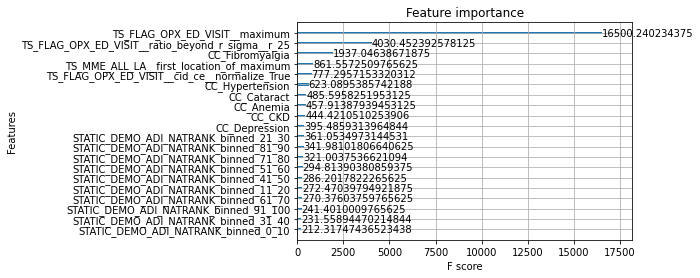

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

In [0]:
xgb.plot_importance(booster, max_num_features=20, importance_type='gain')

In [0]:
preds = booster.predict(xgb.DMatrix(test.drop('labels').toPandas())).astype('float64')
preds

Out[93]: array([2.66017742e-03, 8.95824123e-05, 1.96015491e-04, ...,
 5.47709460e-05, 2.97724619e-05, 8.00337966e-06])

### Save the base XGB model

We want to be able to compare these models without constantly retraining, so we pickle them.

In [0]:
import pickle
with open('/dbfs/mnt/eldb_mnt/JDE328/noblis_pkl/xgb_for_fbt.pkl', 'wb') as file:
  pickle.dump(booster, file)

## Train the XGBoostTreeApproximator

Now we train a Tree Approximator (using the `FBT` class) from the trained XGB model.

**NOTE:** This is extremely compute-intensive and not Spark-aware and so runs on the driver node. A typical training run can take upwards of 16 hours. So we can easily do analysis on it later, we also pickle it.

In [0]:
train_pd = train.toPandas()
feature_cols = [col for col in train_pd.columns if col != 'labels']
fbt = FBT(max_depth=5, max_number_of_conjunctions=1000, min_forest_size=10) #, pruning_method='auc')
fbt.fit(train_pd.sample(frac=0.001), 
        feature_cols, 'labels', booster)


--------------------------------------------------------------------------- 
 AttributeError Traceback (most recent call last)
 <command-422096> in <module> 
 2 feature_cols = [ col for col in train_pd . columns if col != 'labels' ] 
 3 fbt = FBT ( max_depth = 5 , max_number_of_conjunctions = 1000 , min_forest_size = 10 ) #, pruning_method='auc') 
 ----> 4 fbt.fit(train_pd.sample(frac=0.001), 
 5 feature_cols, 'labels', booster)

 <command-422016> in fit (self, train, feature_cols, label_col, xgb_model, pruned_forest, trees_conjunctions_total) 
 45 self . xgb_model = xgb_model
 46 if pruned_forest is None or trees_conjunctions_total is None : 
 ---> 47 self . trees_conjunctions_total = extractConjunctionSetsFromForest ( self . xgb_model , train [ self . label_col ] . unique ( ) , self . feature_cols ) 
 48 print ( 'Start pruning' ) 
 49 self . prune ( train ) 

 <command-422010> in extractConjunctionSetsFromForest (model, unique_labels, features) 
 107 """
 108 
 --> 109 trees = extractNodesFromModel ( model ) 
 110 num_of_labels = len ( unique_labels ) 
 111 feature_dict = { v : k for k , v in enumerate ( features ) } 

 <command-422010> in extractNodesFromModel (model) 
 20 """
 21 trees = [ ] 
 ---> 22 for tree_string in model . _Booster . get_dump ( ) : 
 23 nodes = [ feature_regex . search ( 't' + node ) . groupdict ( ) if '[' in node else leaf_regex . search ( 't' + node ) . groupdict ( ) for node in tree_string . split ( '\n' ) [ : - 1 ] ] 
 24 trees . append ( nodes ) 

 AttributeError : 'Booster' object has no attribute '_Booster'

In [0]:
import pickle
with open('/dbfs/mnt/eldb_mnt/JDE328/noblis_pkl/fbt_40k.pkl', 'wb') as file:
  pickle.dump(fbt, file)

The full pickled model is nearly 1GB, which will be very slow to load. By bzipping it (to ~10% the size), we dramatically speed up the unpickling process.

In [0]:
%sh bzip2 -k '/dbfs/mnt/eldb_mnt/JDE328/noblis_pkl/fbt_40k.pkl'

In [0]:
# This is how we unpickle the pickled file.
import bz2
import pickle
with open('/dbfs/mnt/eldb_mnt/JDE328/noblis_pkl/fbt_40k.pkl.bz2', 'rb') as infile:
  bzfile = bz2.BZ2File(infile, 'rb')
  rfbt = pickle.load(bzfile)

In [0]:
len(rfbt.tree.conjunctions)

Out[61]: 64497

In [0]:
pred = rfbt.predict_proba(test.drop('labels').toPandas()) # predict() produces class {0,1}; predict_proba() produces class probabilities

In [0]:
# prediction is also slow for some reason, so we pickle predictions
with open('/dbfs/mnt/eldb_mnt/JDE328/noblis_pkl/fbt_40k_pred.pkl', 'wb') as ofile:
  pickle.dump(pred, ofile)

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-427540> in <module> 
 1 # prediction is also slow for some reason, so we pickle predictions 
 2 with open ( '/dbfs/mnt/eldb_mnt/JDE328/noblis_pkl/fbt_40k_pred.pkl' , 'wb' ) as ofile : 
 ----> 3 pickle . dump ( pred , ofile ) 

 NameError : name 'pred' is not defined

In [0]:
import pickle
with open('/dbfs/mnt/eldb_mnt/JDE328/noblis_pkl/fbt_40k_pred.pkl', 'rb') as file:
  rpred = pickle.load(file)
rpred

Out[64]: array([1, 0, 0, ..., 0, 0, 0])

## Comparisons

First, we check the P-R curve for the real XGBoost model.

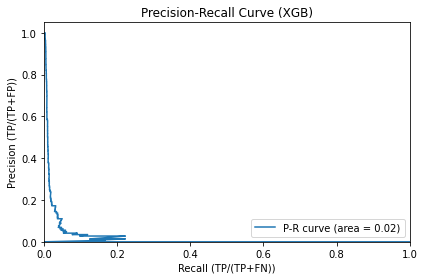

In [0]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# need to use the BinaryClassificationEvaluator for its better numerical flexibility
eval = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='labels', metricName='areaUnderPR')
prediction_pddf = (pd.concat([pd.DataFrame({'rawPrediction': preds}),
                                  test.select('labels').toPandas()],
                                 axis=1))

prauc = eval.evaluate(spark.createDataFrame(prediction_pddf))
precision, recall, thresholds = precision_recall_curve(labels, preds, pos_label=1)
plt.plot(precision, recall, label='P-R curve (area = %0.2f)' % prauc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall (TP/(TP+FN))')
plt.ylabel('Precision (TP/(TP+FP))')
plt.title('Precision-Recall Curve (XGB)')
plt.legend(loc="lower right")
plt.tight_layout()


And now we compare performance with the approximated tree:

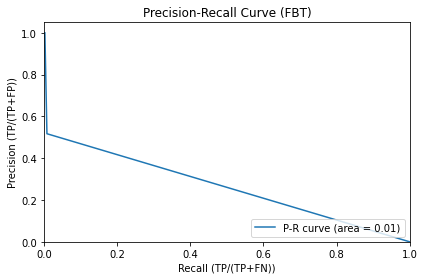

In [0]:
prediction_pddf = (pd.concat([pd.DataFrame({'rawPrediction': rpred.astype('float64')}),
                                  test.select('labels').toPandas()],
                                 axis=1))

prauc = eval.evaluate(spark.createDataFrame(prediction_pddf))
precision, recall, thresholds = precision_recall_curve(labels, rpred, pos_label=1)
plt.plot(precision, recall, label='P-R curve (area = %0.2f)' % prauc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall (TP/(TP+FN))')
plt.ylabel('Precision (TP/(TP+FP))')
plt.title('Precision-Recall Curve (FBT)')
plt.legend(loc="lower right")
plt.tight_layout()

### moving files

In [0]:

%sh cp '/dbfs/mnt/eldb_mnt/CCU877/fbt_40k_pred.pkl' '/dbfs/mnt/eldb_mnt/JDE328/noblis_pkl/'

In [0]:
%sh ls -l '/dbfs/mnt/eldb_mnt/JDE328/noblis_pkl'

total 1113855
-rwxrwxrwx 1 root root 1009044171 Jul 28 01:44 fbt_40k.pkl
-rwxrwxrwx 1 root root 126980367 Jul 28 01:44 fbt_40k.pkl.bz2
-rwxrwxrwx 1 root root 524546 Jul 28 01:45 fbt_40k_pred.pkl
-rwxrwxrwx 1 root root 4036855 Jul 28 01:40 xgb_for_fbt.pkl